In [2]:
# import required libraries
import pandas as pd
import numpy as np
import ccxt
from ta import trend
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import yfinance as yf
from ta import trend
from pymoo.visualization.scatter import Scatter
import random
from deap import base, creator, tools, algorithms
from deap.tools import uniform_reference_points
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Constants
FEE = 0.02
START_BALANCE = 100

In [13]:
def fetch_data(timeframe):
    exchange = ccxt.kraken()
    start_timestamp = 1451606400000  # timestamp for 1 Jan 2016 - this doesn't seem to apply with kraken so we take the earliest date available.
    end_timestamp = 1651392000000  # timestamp for 1 May 2023
    interval_seconds = exchange.parse_timeframe(timeframe)  # convert timeframe to seconds
    limit = int((end_timestamp - start_timestamp) / interval_seconds) + 1
    ohlcv = exchange.fetch_ohlcv('BTC/AUD', timeframe=timeframe, since=start_timestamp, limit=limit)
    return ohlcv

# get stock prices
#ohlcv = yf.download('BTC', start='2020-01-01', threads= False)
ohlcv = fetch_data('1d')

df = pd.DataFrame(ohlcv)
df.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
df

,time,open,high,low,close,volume
0,1621728000000,48482.4,49509.9,40521.3,45347.2,61.982295
1,1621814400000,45405.2,51636.1,44408.0,50154.2,31.160977
2,1621900800000,50480.4,51535.4,47241.3,49280.8,28.347923
3,1621987200000,49644.6,52721.0,49086.0,50652.3,34.723634
4,1622073600000,50748.9,52154.7,48000.0,49789.2,17.808706
...,...,...,...,...,...,...
715,1683504000000,42314.3,42574.4,40390.8,40918.8,21.387002
716,1683590400000,40914.8,41264.3,40631.3,40967.9,15.387367
717,1683676800000,40948.7,41834.2,39757.9,40841.1,17.907335
718,1683763200000,40797.9,40970.2,40034.4,40365.2,10.039696


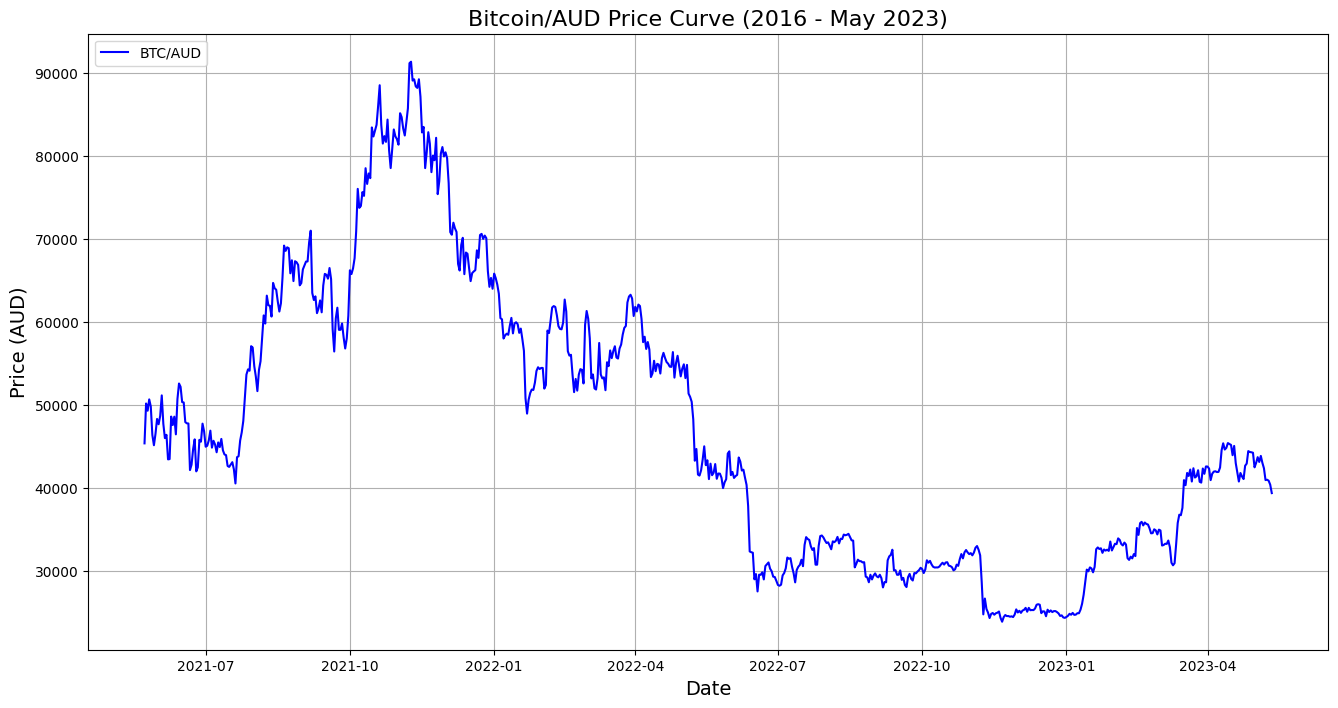

In [14]:
import pandas as pd
import ccxt
import matplotlib.pyplot as plt

def fetch_data(timeframe):
    exchange = ccxt.kraken()
    start_timestamp = 1451606400000  # timestamp for 1 Jan 2016
    end_timestamp = 1651392000000  # timestamp for 1 May 2023
    interval_seconds = exchange.parse_timeframe(timeframe)  # convert timeframe to seconds
    limit = int((end_timestamp - start_timestamp) / interval_seconds) + 1
    ohlcv = exchange.fetch_ohlcv('BTC/AUD', timeframe=timeframe, since=start_timestamp, limit=limit)
    return ohlcv

# Get daily historical data
ohlcv = fetch_data('1d')
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

# Plot the price curve
plt.figure(figsize=(16,8))
plt.plot(df['close'], color='blue', label='BTC/AUD')
plt.title('Bitcoin/AUD Price Curve (2016 - May 2023)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (AUD)', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)

# Save the price curve as a PNG image
plt.savefig('bitcoin_aud_price_curve.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [15]:
def strategy(df, length = 20, mult = 2.0,length_KC = 20, mult_KC = 2.0, stop_loss_pct = 0.05, take_profit_pct=0.05, visualise=False):

    # Prevent genetic algorithm from providing float values instead of required integer values
    length = int(length)
    length_KC = int(length_KC)

    # Array for storing running balance
    running_balance = []

    #Calculate percent change
    epsilon = 1e-8  # Prevents divide by zero errors in genetic algorithm
    df['change'] = df['close'].pct_change(1).fillna(epsilon)

    # calculate Bollinger Bands
    m_avg = trend.sma_indicator(df['close'],window=length)
    #m_avg = df['close'].rolling(window=length).mean()
    m_std = df['close'].rolling(window=length).std(ddof=0)
    df['upper_BB'] = m_avg + mult * m_std
    df['lower_BB'] = m_avg - mult * m_std

    # calculate true range
    df['tr0'] = abs(df["high"] - df["low"])
    df['tr1'] = abs(df["high"] - df["close"].shift())
    df['tr2'] = abs(df["low"] - df["close"].shift())
    df['tr'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)

    # calculate Keltner Channels
    range_ma = df['tr'].rolling(window=length_KC).mean()
    df['upper_KC'] = m_avg + range_ma * mult_KC
    df['lower_KC'] = m_avg - range_ma * mult_KC

    # calculate bar value
    highest = df['high'].rolling(window = length_KC).max()
    lowest = df['low'].rolling(window = length_KC).min()
    m1 = (highest + lowest)/2
    df['value'] = (df['close'] - (m1 + m_avg)/2)
    fit_y = np.array(range(0,length_KC))
    df['value'] = df['value'].rolling(window = length_KC).apply(lambda x: 
                              np.polyfit(fit_y, x, 1)[0] * (length_KC-1) + 
                              np.polyfit(fit_y, x, 1)[1], raw=True)

    # check for 'squeeze'
    df['squeeze_on'] = (df['lower_BB'] > df['lower_KC']) & (df['upper_BB'] < df['upper_KC'])
    df['squeeze_off'] = (df['lower_BB'] < df['lower_KC']) & (df['upper_BB'] > df['upper_KC'])

    # buying window for long position:
    # 1. black cross becomes gray (the squeeze is released)
    long_cond1 = (df['squeeze_off'].shift(2)  == False) & (df['squeeze_off'].shift(1)  == True) 
    # 2. bar value is positive => the bar is light green k
    long_cond2 = df['value'].shift(1)  > 0
    df['enter_long'] = long_cond1 & long_cond2

    # buying window for short position:
    # 1. black cross becomes gray (the squeeze is released)
    short_cond1 = (df['squeeze_off'].shift(2) == False) & (df['squeeze_off'].shift(1)  == True) 
    # 2. bar value is negative => the bar is light red 
    short_cond2 = df['value'].shift(1)  < 0
    df['enter_short'] = short_cond1 & short_cond2

    # Calculate stop-loss and take-profit prices for long positions
    in_long_position = False
    in_short_position = False
    cumulative_return = 1.0
    current_trade_return = 1.0
    all_trades = []

    num_trades = 0
    invalid_run = False

    for i in range(1, len(df)):
        # Long trades
        if df['enter_long'][i] == True and not in_short_position and not in_long_position:
            in_long_position = True
            cumulative_return *= (1 - FEE)
            current_trade_return = 1.0
            num_trades += 1
            
        elif in_long_position:
            current_trade_return *= (1 + df['change'][i])
            if (current_trade_return >= (1+take_profit_pct) or current_trade_return <= (1-stop_loss_pct)):
                in_long_position = False
                cumulative_return *= current_trade_return
                if visualise:
                    print(f'Long return: {current_trade_return - 1}, current total: {cumulative_return}')
                all_trades.append(current_trade_return)
                current_trade_return = 1.0

        # Short trades
        if df['enter_short'][i] == True and not in_long_position and not in_short_position:
            in_short_position = True
            cumulative_return *= (1 - FEE)
            current_trade_return = 1.0
            num_trades += 1

        elif in_short_position:
            current_trade_return *= (1 - df['change'][i])
            if (current_trade_return >= (1+take_profit_pct) or current_trade_return <= (1-stop_loss_pct)):
                in_short_position = False
                cumulative_return *= current_trade_return
                if visualise:
                    print(f'Short return: {current_trade_return - 1}, current total: {cumulative_return}')
                all_trades.append(current_trade_return-1)
                current_trade_return = 1.0
        running_balance.append(cumulative_return*100)
    
    total_risk = np.std(all_trades)
    
    if visualise:
        print(f"Total Return: {round(START_BALANCE*(cumulative_return),2)}'\n'Net Profit: {round((cumulative_return-1)*100,2)}%'\n'Risk: {round(np.std(all_trades)*100,2)}%")
        plt.plot(running_balance)
    if num_trades < 5:
        # We do not consider trading simulations with less than five trades to be valid, as this is neither good enough as a trading strategy over out time frame and it causes erroneous sharpe ratios
        # I.e., a simulation with only a single trade has a standard deviation of zero, causing a divide by zero error
        invalid_run = True
    
    
    return (cumulative_return-1), total_risk, invalid_run

Long return: 0.06382467044613516, current total: 1.0425481770372125
Short return: -0.09028343747170142, current total: 0.9294548770067482
Short return: -0.06538210221045382, current total: 0.8513114599735225
Long return: -0.098841545554477, current total: 0.7518231891310713
Short return: 0.053220232657286815, current total: 0.7759986862902948
Short return: -0.058396456535188435, current total: 0.7160694504802806
Short return: 0.12609062587325726, current total: 0.7902319137468573
Long return: -0.08725696531576466, current total: 0.7068531015564847
Short return: 0.06907304886266208, current total: 0.7405640483714396
Short return: 0.10188802034310718, current total: 0.799698280133337
Long return: -0.08847265325983111, current total: 0.7143679144529647
Short return: 0.055000009614494694, current total: 0.7385849934838409
Short return: 0.0519414764437478, current total: 0.7614092247540957
Long return: -0.10710624359262866, current total: 0.6662603919968307
Long return: 0.05496383229997037,

(-0.47533967455274917, 0.4705378022273993, False)

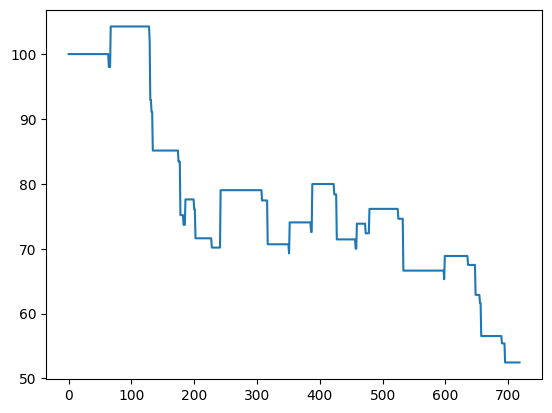

In [16]:
# Example of strategy performance
# Note - trade returns will often largely exceed take-profit and stop-loss due to market moves exceeding set limits too quickly
strategy(df, visualise=True)

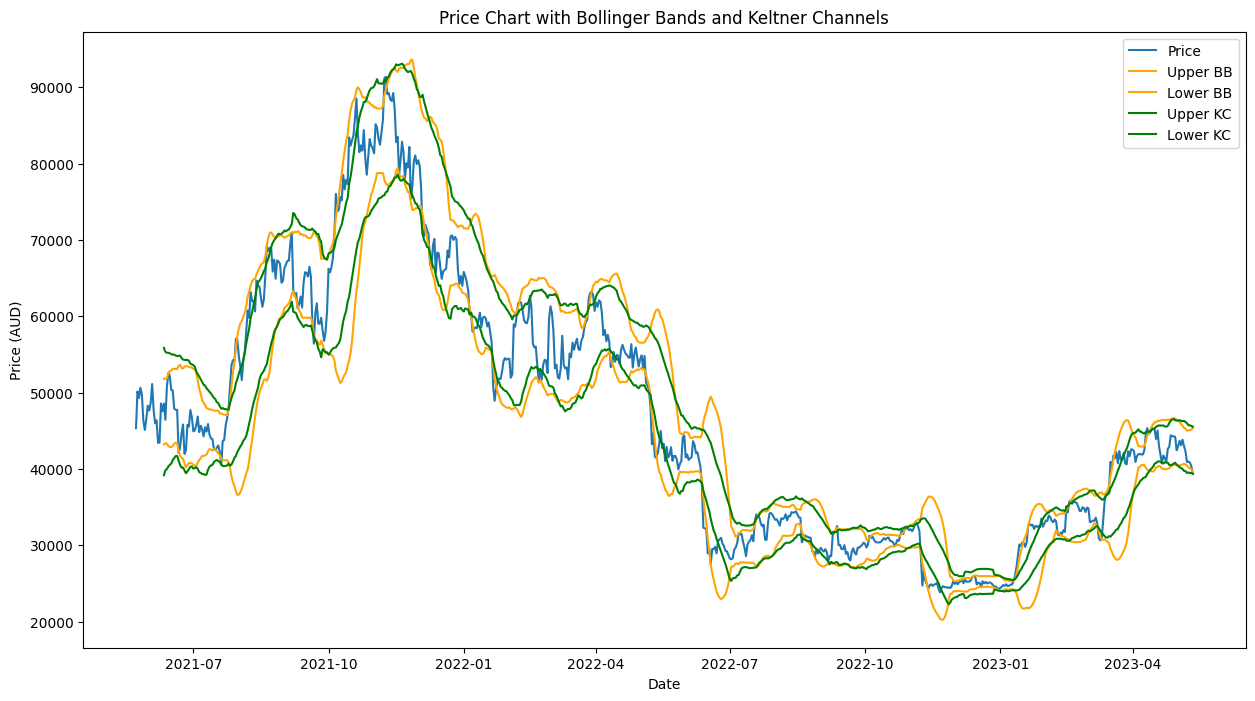

In [17]:
# create the figure and axis objects
fig, ax = plt.subplots(figsize=(15, 8))

# plot the price data
ax.plot(df.index, df['close'], label='Price')

# plot the Bollinger Bands and Keltner Channels
ax.plot(df.index, df['upper_BB'], label='Upper BB', color='orange')
ax.plot(df.index, df['lower_BB'], label='Lower BB', color='orange')
ax.plot(df.index, df['upper_KC'], label='Upper KC', color='green')
ax.plot(df.index, df['lower_KC'], label='Lower KC', color='green')

# set the title and labels
ax.set_title('Price Chart with Bollinger Bands and Keltner Channels')
ax.set_xlabel('Date')
ax.set_ylabel('Price (AUD)')

# add a legend
ax.legend()

# display the plot
plt.savefig('Price Chart with Bollinger Bands and Keltner Channels.png', dpi=300, bbox_inches='tight')
plt.show()


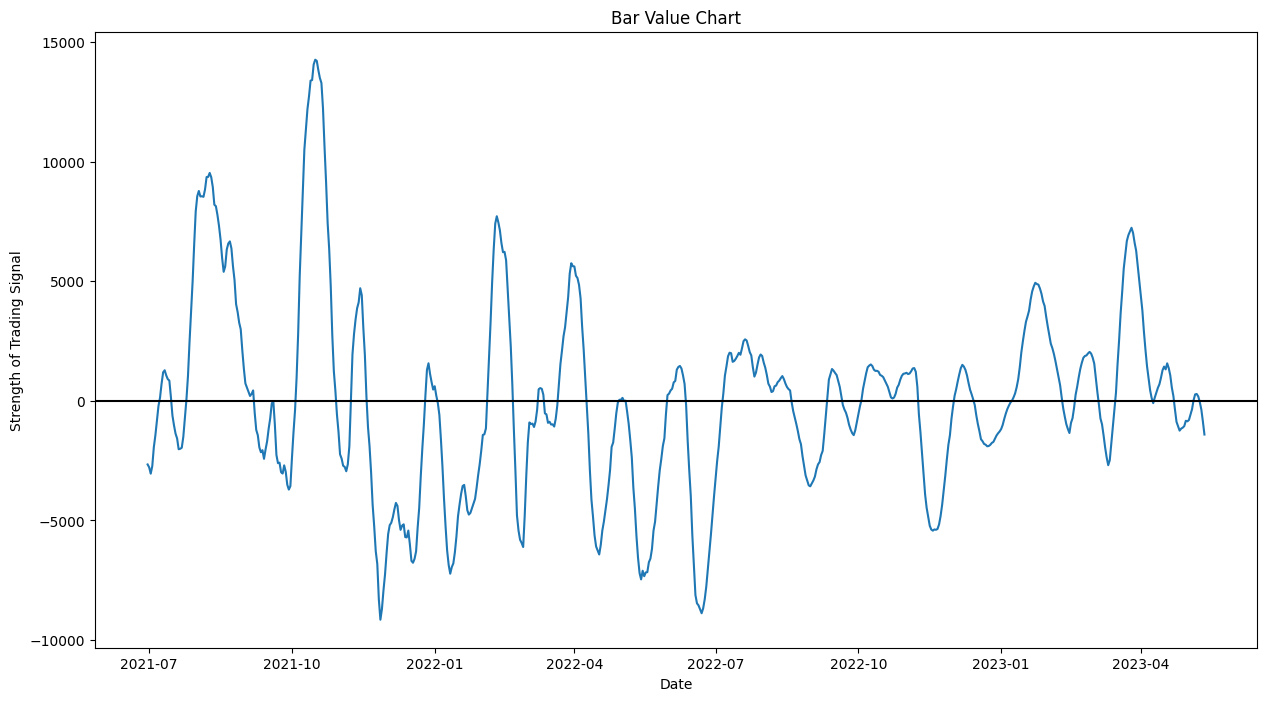

In [18]:
# create the figure and axis objects
fig, ax = plt.subplots(figsize=(15, 8))

# plot the bar value data
ax.plot(df.index, df['value'], label='Bar Value')

# set the title and labels
ax.set_title('Bar Value Chart')
ax.set_xlabel('Date')
ax.set_ylabel('Strength of Trading Signal')

# add a horizontal line at 0 for reference
ax.axhline(y=0, color='black')

# display the plot
plt.savefig('Bar Value Chart.png', dpi=300, bbox_inches='tight')
plt.show()


gen	nevals	avg                      	std                    	min                      	max                    
0  	100   	[-0.38619746  1.94403235]	[0.27019568 0.29067138]	[-0.80790697  1.        ]	[0.21936282 2.37728424]
1  	91    	[-0.22883068  1.92036939]	[0.26683727 0.36611736]	[-0.76751412  1.        ]	[0.71639365 2.37728424]
2  	88    	[-0.08873957  1.83734411]	[0.24073054 0.46559055]	[-0.78365978  1.        ]	[0.71639365 2.37728424]
3  	92    	[-0.10845812  2.10006737]	[0.28131279 0.10675676]	[-0.78365978  1.7914348 ]	[0.71639365 2.37728424]
4  	88    	[-0.04411966  2.12847957]	[0.31940095 0.12594537]	[-0.77376076  1.7914348 ]	[1.02217945 2.48952927]
5  	95    	[-0.01113206  2.16494259]	[0.37446659 0.12454389]	[-0.77376076  1.7914348 ]	[1.02217945 2.48952927]
6  	93    	[0.07491942 2.17126847]  	[0.39802125 0.14936989]	[-0.77376076  1.7914348 ]	[1.02217945 2.48952927]
7  	92    	[0.20738754 2.18557427]  	[0.378741   0.13907883]	[-0.59395118  1.85185794]	[1.02217945 2.48952927]
8

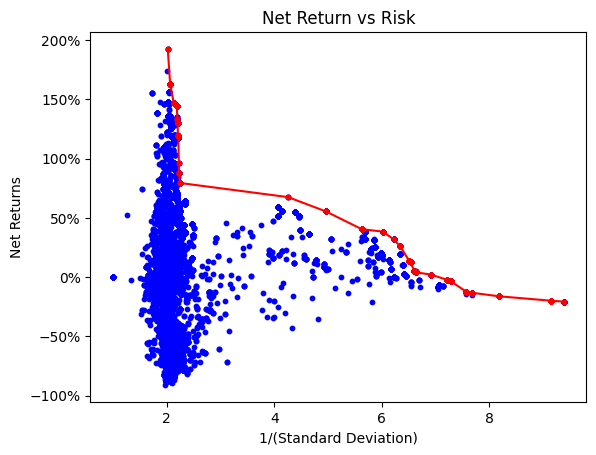

In [165]:
# NSGA-II Algorithm

fitness_results = []
pareto_values = []
strategy_parameters = {}

creator.create("FitnessMulti", base.Fitness, weights=(1.0,1.0))

creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("length", random.randint, 5, 20)
toolbox.register("mult", random.uniform, 1.25, 3.5)
toolbox.register("length_KC", random.randint, 5, 20)
toolbox.register("mult_KC", random.uniform, 1.25, 3.5)
toolbox.register("stop_loss_pct", random.uniform, 0.01, 0.1)
toolbox.register("take_profit_pct", random.uniform, 0.01, 0.1)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.length, toolbox.mult, toolbox.length_KC,
                  toolbox.mult_KC, toolbox.stop_loss_pct, toolbox.take_profit_pct), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)



def evaluate(individual):
    # Convert individual to a tuple before unpacking
    length, mult, length_KC, mult_KC, stop_loss_pct, take_profit_pct = tuple(individual)
    
    # Call the strategy function
    net_profit, std_dev, invalid_run = strategy(df, length, mult, length_KC, mult_KC, stop_loss_pct, take_profit_pct)
    
    # Check for invalid run
    if invalid_run:
        net_profit = 0.0
        std_dev = 1.0  # You may replace this with any default value

    # Append the results
    fitness_results.append((net_profit, 1/std_dev))
    strategy_parameters[(net_profit, 1/std_dev)] = (length, mult, length_KC, mult_KC, stop_loss_pct, take_profit_pct)

    # Return the tuple of fitness values
    return net_profit, 1/std_dev


toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.1)
toolbox.register("select", tools.selNSGA2)
toolbox.register("evaluate", evaluate)


def main():
    random.seed(42)
    NGEN = 100      # Number of generations
    MU = 100         # Population Size
    LAMBDA = 100    # Number of children produced each generation
    CXPB = 0.7      # Crossover rate
    MUTPB = 0.2     # Mutation Probability

    pop = toolbox.population(n=MU)
    hof = tools.ParetoFront()
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats,
                                             halloffame=hof)

    return pop, logbook, hof

if __name__ == "__main__":

    pop, log, hof = main()
    print(pop)
    print("Best solutions found on the Pareto front:")
    for ind in hof:
        if ind.fitness.values[0] != 'nan':
            print(f" Fitness: {ind.fitness.values}")
            pareto_values.append(ind.fitness.values)
    

    # Visualisation of Results
    fitness_x = [t[1] for t in fitness_results]
    fitness_y = [t[0] for t in fitness_results]
    pareto_x = [t[1] for t in pareto_values]
    pareto_y = [t[0] for t in pareto_values]
    fitness_y = [y * 100 for y in fitness_y]
    pareto_y = [y * 100 for y in pareto_y]
    plt.scatter(x=fitness_x, y=fitness_y, color='blue', label='All Results', s=10)
    plt.scatter(x=pareto_x, y=pareto_y, color='red', label='Pareto Set', s=10)
    for i in range(len(pareto_x)-1):
        plt.plot([pareto_x[i], pareto_x[i+1]], [pareto_y[i], pareto_y[i+1]], color='red')
    plt.xlabel('1/(Standard Deviation)')
    plt.ylabel('Net Returns')
    plt.title('Net Return vs Risk')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mticker.PercentFormatter())

    

In [166]:

pareto_parameters = pd.DataFrame(columns=['Bollinger_Window', 'Bollinger_Multiplier', 'Keltner_Channel_Window',
                                          'Keltner_Channel_Multiplier', 'Stop_Loss_Pct', 'Take_Profit_Pct', 'Net_Profit', '1/Standard_Deviation','Sharpe_Ratio'])
for i in pareto_values:
        net_profit = i[0]
        inv_std_dev = i[1]
        vals = strategy_parameters[(net_profit, inv_std_dev)]

        # Append the row to the DataFrame
        pareto_parameters = pareto_parameters.append({
            'Bollinger_Window': vals[0],
            'Bollinger_Multiplier': vals[1],
            'Keltner_Channel_Window': vals[2],
            'Keltner_Channel_Multiplier': vals[3],
            'Stop_Loss_Pct': vals[4],
            'Take_Profit_Pct': vals[5],
            'Net_Profit': net_profit,
            '1/Standard_Deviation': inv_std_dev,
            'Sharpe_Ratio': net_profit/(1/inv_std_dev)
        }, ignore_index=True)

pareto_parameters.sort_values(by=['Sharpe_Ratio'])
pareto_parameters

,Bollinger_Window,Bollinger_Multiplier,Keltner_Channel_Window,Keltner_Channel_Multiplier,Stop_Loss_Pct,Take_Profit_Pct,Net_Profit,1/Standard_Deviation,Sharpe_Ratio
0,17.286981,2.272622,18.000000,2.855416,0.321554,0.137294,1.926494,2.019127,3.889836
1,17.286981,2.272622,18.000000,2.855416,0.321554,0.137294,1.926494,2.019127,3.889836
2,17.403986,1.893866,18.000000,2.855416,0.138016,0.105421,1.634194,2.062915,3.371203
3,17.403986,1.893866,18.000000,2.855416,0.138016,0.105421,1.634194,2.062915,3.371203
4,17.403986,1.893866,18.000000,2.855416,0.138016,0.105421,1.634194,2.062915,3.371203
...,...,...,...,...,...,...,...,...,...
178,17.205052,3.173689,4.870035,1.492548,0.095225,0.105421,-0.198375,9.149118,-1.814956
179,17.205052,3.173689,4.870035,1.492548,0.095225,0.105421,-0.198375,9.149118,-1.814956
180,17.205052,3.173689,4.870035,1.492548,0.095225,0.105421,-0.198375,9.149118,-1.814956
181,17.286981,3.218320,4.882259,1.491938,0.095225,0.105421,-0.206000,9.385563,-1.933426


Long return: 0.16391261482894315, current total: 1.1406343625323643
Long return: 0.14066230698780546, current total: 1.2750570509278167
Long return: 0.16647998785005624, current total: 1.45758196260892
Short return: 0.17481068824515034, current total: 1.6781352112929762
Short return: 0.15067795942215145, current total: 1.8923733365537616
Short return: 0.15392725999030943, current total: 2.139987955545638
Short return: 0.1380931450814793, current total: 2.3867955103081515
Long return: 0.13992156807869827, current total: 2.6663444871777915
Long return: 0.14282362864013276, current total: 2.986218252400315
Total Return: 292.65'
'Net Profit: 192.65%'
'Risk: 49.53%


(1.9264938873523088, 0.49526354186005705, False)

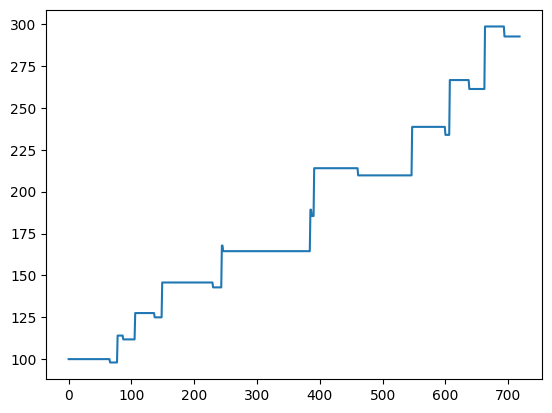

In [168]:
# To see how each of the results in the pareto front perform, simply copy a row's values from 'Bollinger_Window' to 'Take_Profit_Pct' into the strategy parameters.
strategy(df, 17.286981, 2.272622, 18.000000, 2.855416, 0.321554, 0.137294, visualise=True)